In [56]:
# General stuff
import os
import re
import time
import warnings
import math
import sys
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from subprocess import Popen, PIPE
from os.path import join as opj
from IPython.core.debugger import Tracer
from nilearn.decomposition import CanICA,DictLearning
from sklearn.decomposition import DictionaryLearning

# sklearn stuff
from sklearn.decomposition import TruncatedSVD,FastICA,SparsePCA,MiniBatchSparsePCA
from sklearn.utils.extmath import randomized_svd
from sklearn.linear_model import Ridge
from sklearn.decomposition import dict_learning_online
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import scale
import sklearn.metrics.cluster as metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster.hierarchical import _hc_cut # Internal function to cut ward tree, helps speed up things a lot
from sklearn.utils import resample
from sklearn.model_selection import KFold

# personal functions
from importlib import reload
import fsutils as fs
reload(fs)

if os.path.exists('/data1/vbeliveau/'):
    # On NRU server
    cluster_code='/data1/vbeliveau/5HT_clustering'
    cluster_data='/data1/vbeliveau/5HT_clustering_data'
    subjects_dir='/usr/local/nru/freesurfer/subjects'
elif os.path.exists('C:/Users/vbeliveau/'):
    # On laptop
    cluster_code='C:/Users/vbeliveau/Documents/GitHub/5HT_clustering'
    cluster_data='C:/Users/vbeliveau/Documents/5HT_clustering_data'
    subjects_dir='C:/Users/vbeliveau/Downloads/'
else:
    raise ValueError('Unknown location')
    
# Load local version of nilearn
if os.path.exists('/data1/vbeliveau/'):
    sys.path.append('/data1/vbeliveau/nilearn')
    import mynilearn.decomposition as dcm 
    reload(dcm)
elif os.path.exists('C:/Users/vbeliveau/'):
    sys.path.append('C:/Users/vbeliveau/Downloads/nilearn-master')
    import mynilearn.decomposition as dcm
    reload(dcm)
else:
    raise ValueError('Unknown location')
    
# Analysis directories
surf_data=opj(cluster_data,'surf_data')
fs.assert_dir(surf_data)
BPnd_data=opj(cluster_data,'BPnd')
fs.assert_dir(BPnd_data)

info_path=opj(cluster_code,'info_alltracers_base_healthy_hrrt.mat')
hemi_type=['lh','rh']

info=sio.loadmat(info_path)
tracers=['cumi','dasb','sb','az','C36']
petID=np.array([item for subl in info['petID'] for subsubl in subl for item in subsubl])

# define MSMdir
msmDir_code = '/data1/vbeliveau/software/MSM_HOCR_v1/Centos/' # new version
msmDir_rawdata = '/data1/vbeliveau/5HT_clustering_data/surf_data/bpnd.mrtm2.nopvc.ico'
msmDir_analysis = '/data1/Ganz/Vincent'; # change this to a place we both can write?
msmDir_data = opj(msmDir_analysis,'surf_data','bpnd.mrtm2.nopvc.ico')
fs.assert_dir(msmDir_data) 

In [57]:
# load data
tracers=['cumi'] #,'dasb','sb','az','C36']
hemi_type=['lh'] #,'rh']
ico='6'
smN='3'

for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    subjlist=petID[np.array([re.search('^'+tracer,x) is not None for x in petID])]
    for hemi in hemi_type:
        data=np.ndarray(len(subjlist),dtype=object)
        for subj,ns in zip(subjlist,np.arange(0,len(subjlist))):        
            fname=opj(msmDir_rawdata,subj + '.ico' + ico + '.' +hemi +'.smN' + smN,'bp.nii.gz')
            data[ns] = fs.load_surf_data(fname)        
            fname2=opj(msmDir_data,subj + '.ico' + ico + '.' +hemi +'.smN' + smN+'.txt')
            np.savetxt(fname2,data[ns],fmt='%.10f')
        # Save mean out
        fname3=opj(msmDir_data,tracer+'.mean.ico' + ico + '.' +hemi +'.smN' + smN+'.txt')
        np.savetxt(fname3,np.vstack(data).mean(axis=0),fmt='%.10f')
            

In [58]:
# run msms command
tracers=['cumi'] #,'dasb','sb','az','C36']
hemi_type=['lh'] #,'rh']
ico='6'
smN='3'
if ico=='7':
    targ='fsaverage'
else:
    targ='fsaverage'+ico

# define config file, see https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MSM/UserGuide for details
configFile = opj(msmDir_analysis,'msm_sulc_depth.config')

# Procedure 
# 1) use sulc aligned functional data on the spherical mesh and align the single subject once given 
# definition of spherical mesh
inmesh_file = opj('/usr/local/nru/freesurfer/subjects',targ,'surf/lh.sphere.shape.gii')

for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    subjlist=petID[np.array([re.search('^'+tracer,x) is not None for x in petID])]
    for hemi in hemi_type:
        for subj in subjlist:
            outDir = opj(msmDir_analysis,subj + '.ico' + ico + '.' +hemi +'.smN' + smN+'/') # msm needs dash at end of outputdir
            fs.assert_dir(outDir)           
            log_file=open(opj(outDir,subj + '.ico' + ico  + '.' +hemi +'.smN' + smN +'.log'),'w')
            indata_file = opj(msmDir_data,subj + '.ico' + ico  + '.' +hemi +'.smN' + smN + '.txt')
            refdata_file = opj(msmDir_data,tracer + '.mean.ico' + ico + '.' +hemi +'.smN' + smN + '.txt')            

            p=Popen([msmDir_code+'/msm','--indata='+indata_file,'--refdata='+refdata_file,'--inmesh='+inmesh_file,
                              '--out='+outDir,'--conf='+configFile,'-v'],stdout=log_file, stderr=log_file)
            
            p.communicate()
            log_file.close()




In [109]:
tracers=['cumi'] #,'dasb','sb','az','C36']
hemi_type=['lh'] #,'rh']
ico='6'
smN='3'
if ico=='7':
    targ='fsaverage'
else:
    targ='fsaverage'+ico

# 2) transform functional data on each subject and redefine an atlas based on the transformed subjects
# in the msm output folder there is already a file called resampledandprojected.func.gii which is the input data 
# passed through the MSM warp and projected onto the target surface (useful for vertex-wise comparison with the target). 
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    subjlist=petID[np.array([re.search('^'+tracer,x) is not None for x in petID])]
    for hemi in hemi_type:
        data=np.ndarray(len(subjlist),dtype=object)
        for subj,ns in zip(subjlist,np.arange(0,len(subjlist))):        
            outDir = opj(msmDir_analysis,subj + '.ico' + ico + '.' +hemi +'.smN' + smN) 
            fs.assert_dir(outDir) 
            fname=opj(outDir,'transformed_and_reprojected.func.gii')
            gstruct = nib.load(fname)
            data[ns]=gstruct.darrays[0].data
        # Save new mean out
        fname2=opj(msmDir_analysis,tracer+'.mean.ico' + ico + '.' +hemi +'.smN' + smN+'.new.txt')
        mean_data = np.vstack(data).mean(axis=0)
        np.savetxt(fname3,mean_data,fmt='%.10f')



0.281578375
0.939953893763


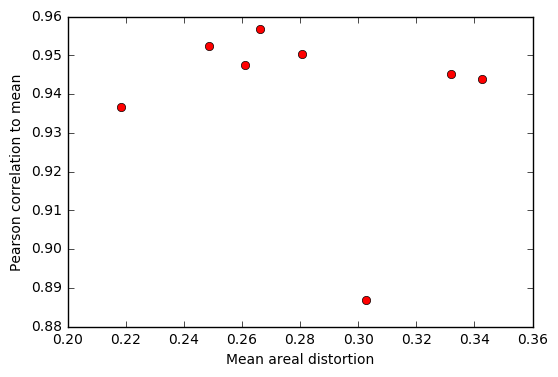

In [164]:
tracers=['cumi'] #,'dasb','sb','az','C36']
hemi_type=['lh'] #,'rh']
ico='6'
smN='3'
if ico=='7':
    targ='fsaverage'
else:
    targ='fsaverage'+ico

# 3) evaluate areal distortion and correlation
inmesh_file = opj('/usr/local/nru/freesurfer/subjects',targ,'surf/lh.sphere.shape.gii')

for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    subjlist=petID[np.array([re.search('^'+tracer,x) is not None for x in petID])]
    for hemi in hemi_type:
        areal_dist=np.ndarray(len(subjlist),dtype=object)
        subj_mean_corr=np.ndarray(len(subjlist),dtype=object)
        for subj,ns in zip(subjlist,np.arange(0,len(subjlist))): 
            outDir = opj(msmDir_analysis,subj + '.ico' + ico + '.' +hemi +'.smN' + smN+'/') # msm needs dash at end of outputdir
            fs.assert_dir(outDir) 
            log_file_name = opj(outDir,subj + '.ico' + ico  + '.' +hemi +'.smN' + smN +'.distortion.log')
            log_file=open(log_file_name,'w')
            transformedmesh_file = opj(outDir,'sphere.reg.surf.gii')
            # areal distortion
            p=Popen([msmDir_code+'/estimate_metric_distortion',inmesh_file,transformedmesh_file,outDir,'-abs'],stdout=log_file, stderr=log_file)
            p.communicate()
            log_file.close()
            # extract mean areal distortion from log file
            with open(log_file_name) as f:
                f = f.readlines()
            for line in f:   
                 if "mean=" in line:
                        pos = line.find('=')
                        areal_dist[ns] = float(line[pos+1:pos+9])
                        break
                
            
            # correlation
            # load individual transformed surfaces and new mean and calculate Pearson correlation coefficient
            fname_ind=opj(outDir,'transformed_and_reprojected.func.gii')
            gstruct = nib.load(fname_ind)
            data1=gstruct.darrays[0].data
            fname_mean=opj(msmDir_analysis,tracer+'.mean.ico' + ico + '.' +hemi +'.smN' + smN+'.new.txt')
            data2 = np.loadtxt(fname_mean)
            c = np.corrcoef(data1,data2)
            subj_mean_corr[ns] = c[0][1]

    # print the mean areal distortion and correlation to mean over all single subjects for a given tracer
    print(np.mean(areal_dist))
    print(np.mean(subj_mean_corr))
    
    # show areal distortion and correlation to mean over all single subjects for a given tracer
    fig = plt.figure()
    p=np.array([1,-3,5])
    q=np.array([3,2,6])
    plt.plot(areal_dist,subj_mean_corr,'ro')
    plt.xlabel('Mean areal distortion')
    plt.ylabel('Pearson correlation to mean')
    plt.show()
